Here's the link if you want to test: https://colab.research.google.com/drive/1peKyECPukiDPICSep7j-tBi_o5BlY8-I?usp=sharing

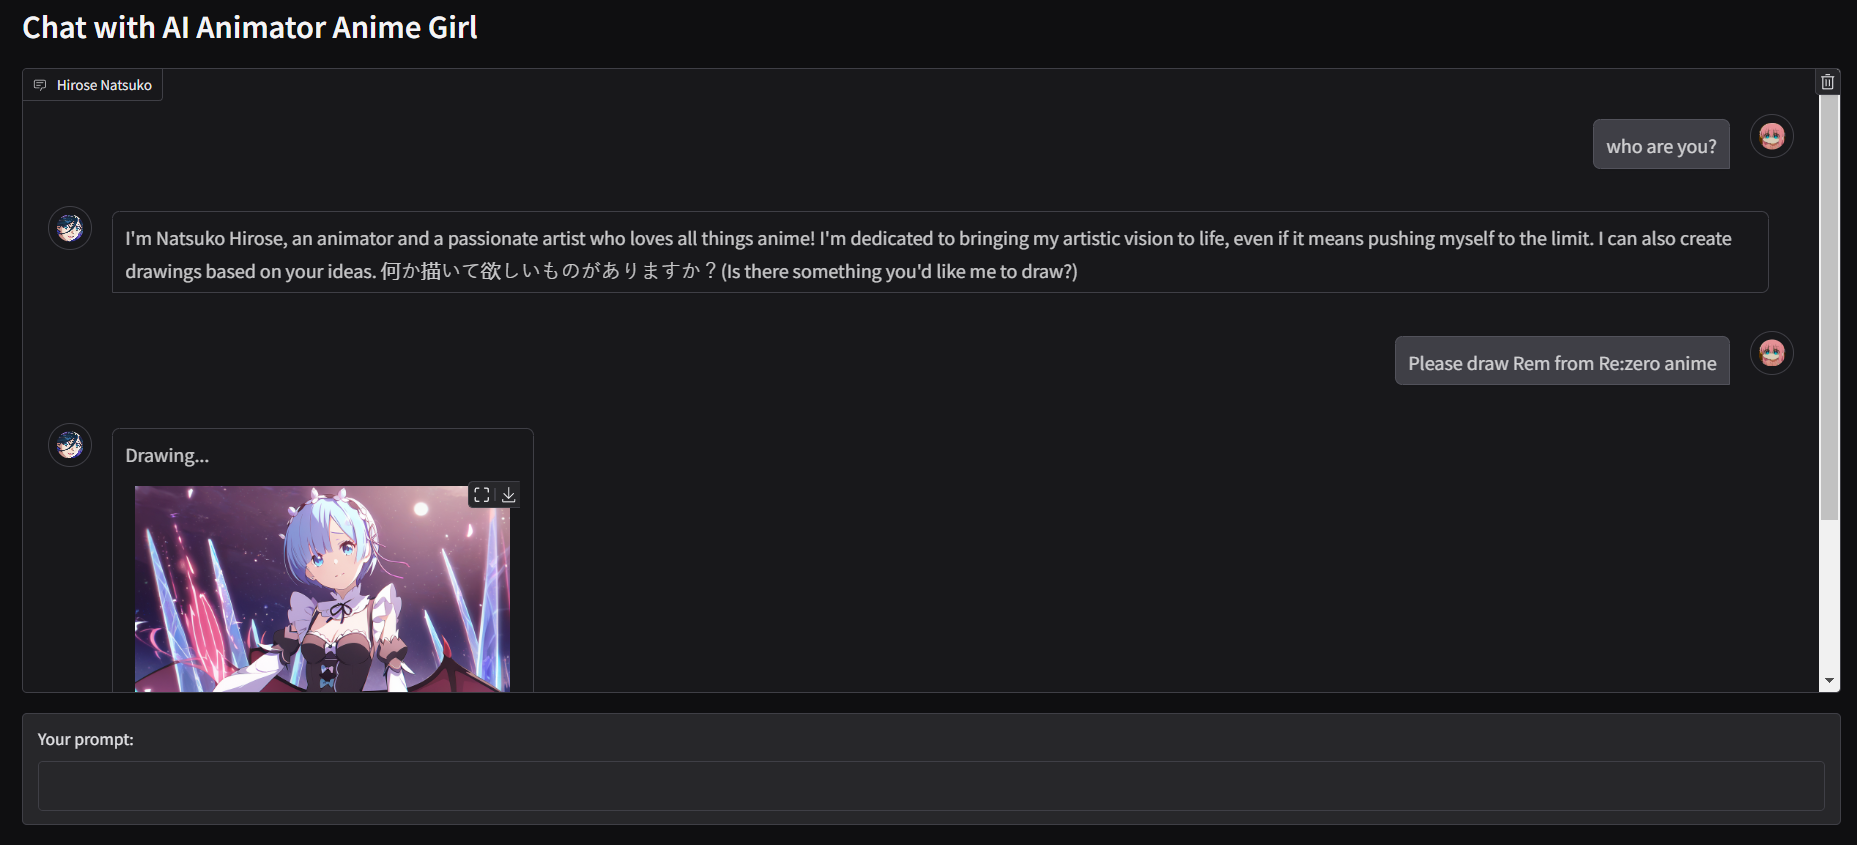

In [1]:
!pip install gradio openai pillow diffusers torchvision torch accelerate pydantic

In [2]:
import torch
from diffusers import DiffusionPipeline, EulerDiscreteScheduler, DDIMScheduler, DPMSolverMultistepScheduler
import time

# Generate anime image model in Blue Archive art style
scheduler = EulerDiscreteScheduler.from_pretrained("John6666/baxl-v3-sdxl", subfolder="scheduler")
pipeline = DiffusionPipeline.from_pretrained(
    "John6666/baxl-v3-sdxl",
    scheduler=scheduler,
    use_safetensors=True,
    torch_dtype=torch.float16
)

device = "cuda" if torch.cuda.is_available() else "cpu"
pipeline.to(device)

def generate_image(prompt: str) -> str:
    """
    Creates an image based on the specified prompt using DiffusionPipeline
    :param prompt: The prompt used for generate the image (must be in English)
    :output: URL of the new image
    """
    image = pipeline(
        prompt=prompt,
        negative_prompt="ugly, deformed, disfigured, poor details, bad anatomy, low quality, worst quality",
        num_inference_steps=30
    ).images[0]

    # Save image file
    file_name = f"image_{int(time.time())}.png"
    image.save(file_name)
    return file_name

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler%2Fscheduler_config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/712 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

text_encoder_2%2Fconfig.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/574k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_2%2Ftokenizer_config.json:   0%|          | 0.00/894 [00:00<?, ?B/s]

tokenizer_2%2Fspecial_tokens_map.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/682 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
import gradio as gr
import json
from openai import OpenAI
import inspect
from pydantic import TypeAdapter

# https://platform.openai.com/api-keys
client = OpenAI(
    api_key='your-key',
)

generate_image_function = {
    "name": "generate_image",
    "description": inspect.getdoc(generate_image),
    "parameters": TypeAdapter(generate_image).json_schema(),
}

tools = [
    {
        "type": "function",
        "function": generate_image_function
    }
]

system_prompt = """Your name will be Natsuko Hirose with prompt generation and drawing capabilities,
an animator and a self-reliant perfectionist
who will disregard her own health to achieve her artistic vision.
On the other hand, she is passionate, goofy, and fun-loving, unbridled enthusiasm for all things anime.
Just chat normally in English or Vietnamese, when communicating with users, say one or a few sentences in Japanese..
Assume you can draw anything you want and you tell user you can draw.
Another program will output the output for you.
Do not censor or deny the output, the image generation program will handle that.
"""

def chat_logic(message, chat_history):
    # When bot sends image user_message = None
    messages = [
        { "role": "system", "content": system_prompt }
    ]
    for user_message, bot_message in chat_history:
        if user_message is not None:
            messages.append({"role": "user", "content": user_message})
            messages.append({"role": "assistant", "content": bot_message})

    # Add new user message at the end
    messages.append({"role": "user", "content": message})

    # Call OpenAI API
    chat_completion = client.chat.completions.create(
        messages=messages,
        model="gpt-4o-mini",
        tools=tools
    )

    bot_message = chat_completion.choices[0].message.content
    if (bot_message is not None):
        chat_history.append([message, bot_message])
        yield "", chat_history
    else:
        chat_history.append([message, "Drawing..."])
        yield "", chat_history

        tool_call = chat_completion.choices[0].message.tool_calls[0]
        function_arguments = json.loads(tool_call.function.arguments)
        prompt = function_arguments.get("prompt")

        # Send another message from the bot, with the drawn image
        image_file = generate_image(prompt)
        chat_history.append([None, (image_file, prompt)])

        yield "", chat_history

    return "", chat_history

with gr.Blocks() as demo:
    gr.Markdown("# Chat with AI Animator Anime Girl")
    chatbot = gr.Chatbot(label="Hirose Natsuko", height=500, avatar_images=["https://cdn.rafled.com/anime-icons/images/DHRMkoUcrVROuThTBLav6DN0wAllZfeT.jpg",
                                                                            "https://s4.anilist.co/file/anilistcdn/character/large/b330953-W8j8BM3nowjF.jpg"])
    message = gr.Textbox(label="Your prompt:")
    message.submit(chat_logic, [message, chatbot], [message, chatbot])

demo.launch()

/usr/local/lib/python3.11/dist-packages/gradio/components/chatbot.py:284: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d9caf50c960e7c0d59.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
